## Subfigure a: Thermochemical + Tidal

In [1]:
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK
from matplotlib.legend_handler import HandlerTuple
import numpy as NP
import os
import pandas as PD
from scipy.constants import Julian_year
from scipy.signal import savgol_filter as SGF
from scipy.interpolate import interp1d ## zwb 20241017, to be revised
import scipy.integrate as integrate
import sys
sys.path.insert(0, os.path.abspath(os.path.join('.', os.pardir)))
from tool_tidal_heat_production import Layer, temporal_evolution_of_tidal_heating, func_interpolate_Earth_Moon_distance

def read_time_DeltaT_from_thermochemical_result():
    file_path = "Dataset2_Evolution_Temperature_Contrast_ThermochemicalModel.csv"
    # Read the CSV file
    df = PD.read_csv(file_path)
    Time = df['Time'] * 1000
    DeltaT = df['DeltaT']
    DeltaT_smoothed = SGF(DeltaT, window_length=11, polyorder=2)
    return Time, DeltaT_smoothed
    
class System_Thermal_Evolution(object):
    def __init__(self, Crust_Layer, Mantle_Layer, LVZ_Layer, Core_Layer, 
                 radio_heating_model, tidal_heating_model, distance_model,
                 T_mic_initial, T_mantle_initial, TotalTime, timestep):
        self.Crust = Crust_Layer
        self.Mantle = Mantle_Layer
        self.LVZ = LVZ_Layer
        self.Core = Core_Layer
        self.radio_heating_model = radio_heating_model
        self.tidal_heating_model = tidal_heating_model
        self.distance_model = distance_model
        self.func_interp_a_RE = func_interpolate_Earth_Moon_distance(distance_model)
        self.initial_conditions = NP.array([T_mic_initial, T_mantle_initial])
        self.upwelling_count = 0 # Counter to track the number of upwellings
        self.time = 0.0
        self.TotalTime = TotalTime
        self.timestep = timestep

    def energy_conservation_mantle(self, mantle_heating_rate):
        lhs_coef = self.Mantle.Rho * self.Mantle.Cp * self.Mantle.Volume
        dTm_dt = mantle_heating_rate * self.Mantle.Volume / lhs_coef 

        return dTm_dt
     
    def energy_conservation_mic(self, mic_heating_rate): ## name changed
        lhs_coef = self.LVZ.Rho * self.LVZ.Cp * self.LVZ.Volume
        dTm_dt = mic_heating_rate * self.LVZ.Volume / lhs_coef 
        
        return dTm_dt

    def calculate_total_heating_rate(self, time):
        

        if (self.distance_model == 'Webb1982') and (time/Julian_year/1e9 < 0.12):
            mic_tidal_heating = 0.0
            mantle_tidal_heating =0.0
        else:
            EM_Distance_RE = self.func_interp_a_RE(4.0 - time/Julian_year/1e9) ## distance （Re）
            mic_tidal_heating, mantle_tidal_heating = temporal_evolution_of_tidal_heating(EM_Distance_RE, self.tidal_heating_model, 
                                                                                          self.Crust, self.Mantle, self.LVZ, self.Core) #W/m^3
        
        mic_heating_rate = mic_tidal_heating 
        mantle_heating_rate = mantle_tidal_heating 

        print(f"Time = {4000 - self.time/Julian_year/1e6} Myr") ##
        print(f"LVZ Tidal Heating Rate = {mic_tidal_heating} W/m^3") 
        print(f"Mantle Tidal Heating Rate = {mantle_tidal_heating} W/m^3") 
        return mic_heating_rate, mantle_heating_rate
    
    def energy_balance(self, time, y):
        T_mic, T_upper_mantle = y 
        self.time = time

        if (T_mic-T_upper_mantle) > (400 * (self.upwelling_count + 1)):
            self.LVZ.radiogenic_fraction *=0.6
            self.upwelling_count +=1
            print("Upwelling !")

        mic_heating_rate, mantle_heating_rate = self.calculate_total_heating_rate(time)
        dTm_dt = self.energy_conservation_mantle(mantle_heating_rate) 
        dTmic_dt  = self.energy_conservation_mic(mic_heating_rate)

        return NP.array([dTmic_dt, dTm_dt])

    def system_solver(self):
        Time, tmp = read_time_DeltaT_from_thermochemical_result()
        ##times = (4.0 - Time) * 1e9 * Julian_year
        Time_interp = NP.linspace(3998, 1000, 301) 
        times = (4000 - Time_interp) * 1e6 * Julian_year
        solution = integrate.solve_ivp(self.energy_balance, (0., self.TotalTime), self.initial_conditions, 
                                       t_eval=times, max_step=(2*self.TotalTime/self.timestep)) 
        return solution

if __name__ == "__main__":
    radius_planet = 1740.e3
    radius_cmb = 340.e3
    lvz_thickness = 300.e3
    crustal_thickness = 45.e3
    initial_Tm = 1250. + 273. ## initial guess
    initial_Tlvz = 1251. + 273. ##
    TotalTime = Julian_year * 3.0e9
    timestep = 301
    RadioMode = 'none'
    TidalMode = 'Andrade'
    Crust_Layer = Layer(inner_radius=radius_planet-crustal_thickness, outer_radius=radius_planet,
                        Density=2800, Viscosity=1e25, ShearWave_Velocity=4500 , PressureWave_Velocity=8000,
                        Heat_Capacity=1250, radiogenic_fraction=0.0)
    Mantle_Layer = Layer(inner_radius=radius_cmb+lvz_thickness, outer_radius=radius_planet-crustal_thickness,
                         Density=3400, Viscosity=1e20,  ShearWave_Velocity=4500 , PressureWave_Velocity=8000,
                         Heat_Capacity=1250, radiogenic_fraction=0.0)
    LVZ_Layer = Layer(inner_radius=radius_cmb, outer_radius=radius_cmb+lvz_thickness,
                      Density=3440, Viscosity=1e17,  ShearWave_Velocity=3500 , PressureWave_Velocity=7000,
                      Heat_Capacity=1250, radiogenic_fraction=0.0)
    Core_Layer = Layer(inner_radius=0, outer_radius=radius_cmb,
                       Density=7800, Viscosity=0.1,  ShearWave_Velocity=0.1 , PressureWave_Velocity=4000,
                       Heat_Capacity=800, radiogenic_fraction=0.0)
    
    Time, DeltaT = read_time_DeltaT_from_thermochemical_result()
    func_interp_DeltaT = interp1d(Time, DeltaT, kind='linear', fill_value='extrapolate')
    Time_interp = NP.linspace(3998, 1000, 301) 
    DeltaT_smoothed = func_interp_DeltaT(Time_interp)
 
    time_before_present = Time_interp/1e3 ##zwb 20241017, to be revised
    #-------------------------#
    #Lower Bound: Tyler2021_40#
    #-------------------------#
    Moon_Tyler2021_40 = System_Thermal_Evolution(Crust_Layer, Mantle_Layer, LVZ_Layer, Core_Layer, 
                                                 RadioMode, TidalMode, 'Tyler2021_40',
                                                 initial_Tlvz, initial_Tm, TotalTime, timestep)
    solution = Moon_Tyler2021_40.system_solver() 
    T_lvz = solution.y[0]
    T_mantle = solution.y[1]
    T_difference = (T_lvz - T_mantle) 
    DeltaT_Sum_Tyler2021_40 = T_difference + DeltaT_smoothed

    #----------------------#
    #Upper Bound: Webb 1982#
    #----------------------#
    Moon_Webb1982 = System_Thermal_Evolution(Crust_Layer, Mantle_Layer, LVZ_Layer, Core_Layer, 
                                                 RadioMode, TidalMode, 'Webb1982',
                                                 initial_Tlvz, initial_Tm, TotalTime, timestep)
    solution = Moon_Webb1982.system_solver() 
    T_lvz = solution.y[0]
    T_mantle = solution.y[1]
    T_difference = (T_lvz - T_mantle) 
    DeltaT_Sum_Webb1982 = T_difference + DeltaT_smoothed
    #------------------------#
    #Middle: Webb1982 Maxwell#
    #------------------------#
    Moon_Webb1982_Maxwell = System_Thermal_Evolution(Crust_Layer, Mantle_Layer, LVZ_Layer, Core_Layer, 
                                                    RadioMode, 'Maxwell', 'Webb1982',
                                                    initial_Tlvz, initial_Tm, TotalTime, timestep)
    solution = Moon_Webb1982_Maxwell.system_solver() 
    T_lvz = solution.y[0]
    T_mantle = solution.y[1]
    T_difference = (T_lvz - T_mantle) 
    DeltaT_Sum_Webb1982_Maxwell = T_difference + DeltaT_smoothed


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Time = 4000.0 Myr
LVZ Tidal Heating Rate = 2.451300992462985e-09 W/m^3
Mantle Tidal Heating Rate = 3.507954898407367e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 2.451300992462985e-09 W/m^3
Mantle Tidal Heating Rate = 3.507954898407367e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 2.451300992462985e-09 W/m^3
Mantle Tidal Heating Rate = 3.507954898407367e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 2.451300992462985e-09 W/m^3
Mantle Tidal Heating Rate = 3.507954898407367e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 2.451300992462985e-09 W/m^3
Mantle Tidal Heating Rate = 3.507954898407367e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 2.451300992462985e-09 W/m^3
Mantle Tidal Heating Rate = 3.507954898407367e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 2.451300992462985e-09 W/m^3
Mantle Tidal Heating Rate = 3.507954898407367e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 2.451300992462985e-09 W/m^3
Mantle Tidal Heating Rate = 3.5079548984

/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Time = 3876.8777724503425 Myr
LVZ Tidal Heating Rate = 6.966205990161131e-07 W/m^3
Mantle Tidal Heating Rate = 1.0025145237523077e-08 W/m^3
Time = 3876.8777724503425 Myr
LVZ Tidal Heating Rate = 6.966205990161131e-07 W/m^3
Mantle Tidal Heating Rate = 1.0025145237523077e-08 W/m^3
Time = 3893.785392376064 Myr
LVZ Tidal Heating Rate = 0.0 W/m^3
Mantle Tidal Heating Rate = 0.0 W/m^3
Time = 3892.272424930287 Myr
LVZ Tidal Heating Rate = 0.0 W/m^3
Mantle Tidal Heating Rate = 0.0 W/m^3
Time = 3884.7075877014013 Myr
LVZ Tidal Heating Rate = 0.0 W/m^3
Mantle Tidal Heating Rate = 0.0 W/m^3
Time = 3883.3627277495993 Myr
LVZ Tidal Heating Rate = 0.0 W/m^3
Mantle Tidal Heating Rate = 0.0 W/m^3
Time = 3881.681652809847 Myr
LVZ Tidal Heating Rate = 0.0 W/m^3
Mantle Tidal Heating Rate = 0.0 W/m^3
Time = 3881.681652809847 Myr
LVZ Tidal Heating Rate = 0.0 W/m^3
Mantle Tidal Heating Rate = 0.0 W/m^3
Time = 3878.655717918293 Myr
LVZ Tidal Heating Rate = 8.588457778190808e-07 W/m^3
Mantle Tidal Heating Rat

/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Time = 4000.0 Myr
LVZ Tidal Heating Rate = 3.826670508151962e-08 W/m^3
Mantle Tidal Heating Rate = 5.455888488617359e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 3.826670508151962e-08 W/m^3
Mantle Tidal Heating Rate = 5.455888488617359e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 3.826670508151962e-08 W/m^3
Mantle Tidal Heating Rate = 5.455888488617359e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 3.826670508151962e-08 W/m^3
Mantle Tidal Heating Rate = 5.455888488617359e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 3.826670508151962e-08 W/m^3
Mantle Tidal Heating Rate = 5.455888488617359e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 3.826670508151962e-08 W/m^3
Mantle Tidal Heating Rate = 5.455888488617359e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 3.826670508151962e-08 W/m^3
Mantle Tidal Heating Rate = 5.455888488617359e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 3.826670508151962e-08 W/m^3
Mantle Tidal Heating Rate = 5.4558884886

/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Time = 4000.0 Myr
LVZ Tidal Heating Rate = 4.0435586293553376e-09 W/m^3
Mantle Tidal Heating Rate = 5.773895163609097e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 4.0435586293553376e-09 W/m^3
Mantle Tidal Heating Rate = 5.773895163609097e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 4.0435586293553376e-09 W/m^3
Mantle Tidal Heating Rate = 5.773895163609097e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 4.0435586293553376e-09 W/m^3
Mantle Tidal Heating Rate = 5.773895163609097e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 4.0435586293553376e-09 W/m^3
Mantle Tidal Heating Rate = 5.773895163609097e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 4.0435586293553376e-09 W/m^3
Mantle Tidal Heating Rate = 5.773895163609097e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 4.0435586293553376e-09 W/m^3
Mantle Tidal Heating Rate = 5.773895163609097e-11 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 4.0435586293553376e-09 W/m^3
Mantle Tidal Heating Rate = 5.77

/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Time = 4000.0 Myr
LVZ Tidal Heating Rate = 1.0272187921795724e-07 W/m^3
Mantle Tidal Heating Rate = 5.943505557263309e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 1.0272187921795724e-07 W/m^3
Mantle Tidal Heating Rate = 5.943505557263309e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 1.0272187921795724e-07 W/m^3
Mantle Tidal Heating Rate = 5.943505557263309e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 1.0272187921795724e-07 W/m^3
Mantle Tidal Heating Rate = 5.943505557263309e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 1.0272187921795724e-07 W/m^3
Mantle Tidal Heating Rate = 5.943505557263309e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 1.0272187921795724e-07 W/m^3
Mantle Tidal Heating Rate = 5.943505557263309e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 1.0272187921795724e-07 W/m^3
Mantle Tidal Heating Rate = 5.943505557263309e-10 W/m^3
Time = 4000.0 Myr
LVZ Tidal Heating Rate = 1.0272187921795724e-07 W/m^3
Mantle Tidal Heating Rate = 5.94

/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part5_潮汐升温线性叠加/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Time = 3879.092611874484 Myr
LVZ Tidal Heating Rate = 2.367658498792873e-07 W/m^3
Mantle Tidal Heating Rate = 1.488621161730123e-10 W/m^3
Time = 3876.8777724503425 Myr
LVZ Tidal Heating Rate = 1.862704285881465e-07 W/m^3
Mantle Tidal Heating Rate = 1.1712359879874362e-10 W/m^3
Time = 3876.8777724503425 Myr
LVZ Tidal Heating Rate = 1.862704285881465e-07 W/m^3
Mantle Tidal Heating Rate = 1.1712359879874362e-10 W/m^3
Time = 3872.908652044031 Myr
LVZ Tidal Heating Rate = 1.36569428940936e-07 W/m^3
Mantle Tidal Heating Rate = 8.588286209150383e-11 W/m^3
Time = 3870.9240918408755 Myr
LVZ Tidal Heating Rate = 1.2163978818569913e-07 W/m^3
Mantle Tidal Heating Rate = 7.649806354569977e-11 W/m^3
Time = 3861.001290825098 Myr
LVZ Tidal Heating Rate = 8.222834095704551e-08 W/m^3
Mantle Tidal Heating Rate = 5.172255969188687e-11 W/m^3
Time = 3859.2372373111816 Myr
LVZ Tidal Heating Rate = 7.803176345328302e-08 W/m^3
Mantle Tidal Heating Rate = 4.9084276299624786e-11 W/m^3
Time = 3857.0321704187863 M

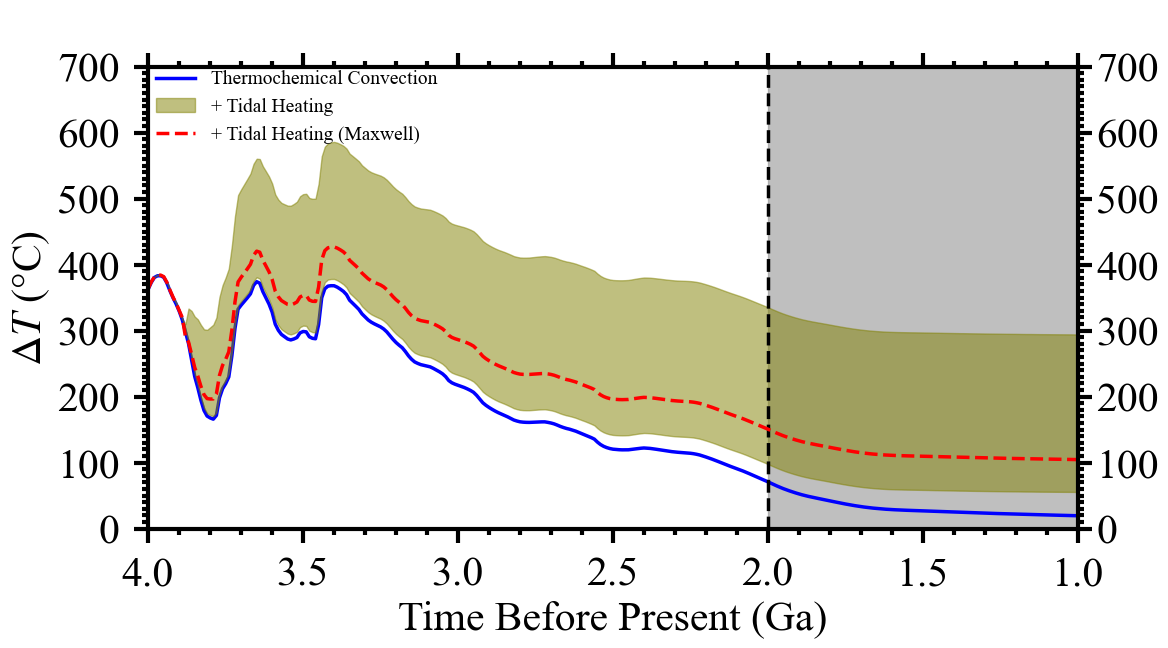

In [18]:
#------------------#
#Plot Configuration#
#------------------#S
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 14
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3
#plot#
fig,ax =PLT.subplots(figsize=(12,6))

thermochemical, = ax.plot(time_before_present, DeltaT_smoothed, linewidth=linewidth_ax, color='blue', linestyle='-')
envelope = ax.fill_between(time_before_present, DeltaT_Sum_Tyler2021_40, DeltaT_Sum_Webb1982, 
                           color='olive', alpha=0.5, zorder=2)

# Fill the area between y1 and y2 with transparency
ax.fill_betweenx([0,700], 2.0, 1.0, color='gray', alpha=0.5)
ax.axvline(x=2.0, color='black', linestyle='--', linewidth=linewidth_ax)
Webb1982_Maxwell, = ax.plot(time_before_present, DeltaT_Sum_Webb1982_Maxwell, linewidth=linewidth_ax, color='red', linestyle='--')
handles = [thermochemical, envelope, Webb1982_Maxwell]
labels = ['Thermochemical Convection', '+ Tidal Heating (Andrade)', "+ Tidal Heating (Maxwell)"]
fig.legend(handles, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, 
    bbox_to_anchor=(0.33,1.03),bbox_transform=ax.transAxes,
    edgecolor='none',facecolor='none',fontsize=legendsize_ax)
#------------------------------#
#Universal Figure configuration#
#------------------------------#
ax.set_xlim(4.0,1.0)
ax.set_ylim(0,700)
ax.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
ax.yaxis.set_major_locator(TICK.MultipleLocator(100))
ax.yaxis.set_minor_locator(TICK.MultipleLocator(10))
ax.tick_params(axis='both',direction='out',length=10,labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
ax.set_xlabel(r"Time Before Present (Ga)",fontsize=labelsize_ax)
ax.set_ylabel(r"$\Delta T$ (°C)",fontsize=labelsize_ax) 
## top x axis
ax2=ax.twiny()
ax2.set_xlim(4.0,1.0)
ax2.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
ax2.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
ax2.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,labelcolor='none',width=borderwidth_ax)
ax2.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
## right y axis
ax3=ax.twinx()
ax3.set_ylim(0,700) 
ax3.yaxis.set_major_locator(TICK.MultipleLocator(100))
ax3.yaxis.set_minor_locator(TICK.MultipleLocator(10))
ax3.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,width=borderwidth_ax)
ax3.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
## overall setting
for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_linewidth(borderwidth_ax)
fig.savefig(f"Figure5_plus_thermochemical.pdf",bbox_inches='tight') 
PLT.show()